# TODO:
### NOW:
- ~~enforce output format for gemini~~
- llama, gpt, ~~claude~~
- ~~add evaluation if there is a golden set for individual model~~
- aggregation strategy and tie breaking
   - multiclass classification: majority vote, baysian approach with GT
      - provide X labeles per class
- add for multi-label/ner
- add images
- add result/eval visualization


### LATER:
- secret management
- send concurrent calls to all models at once
- update readme


### nice things to do:
- add tqdm to asyncio calls
- proper logging

In [ ]:
from utils import Annotate, Evaluate
from datasets import load_dataset

seed =42

In [ ]:
gemini_prompt_template = """
<data_description>
{description}
</data_description>
-----------

<context>
{datapoint}
</context>
------------

<labels>
{labels}
</labels>
------------

INSTRUCTION:
- familirize yourself with the data using data_description
- read the context carefully. this is the data point you need to label.
- take your time and label the dadatapoint with the most appropriate option using the provided labels.
- return the result as a single label from the <labels>. Don't provide explanations
"""

In [ ]:
dataset = load_dataset("yelp_polarity", split="train") # https://huggingface.co/datasets/yelp_polarity

# take a small sample for dev purposes
dataset_sample = dataset.shuffle(seed=seed).select(range(1000))

# user provided data description
DESCRIPTION = """
This is a dataset for binary sentiment classification.
It contains highly polar yelp reviews.
Negative polarity is class 0, and positive class 1.
"""

LABEL_SET = [0, 1] 

In [ ]:
prompt = [gemini_prompt_template.format(description= DESCRIPTION,
                                        datapoint=x,
                                        labels=LABEL_SET) for x in dataset_sample["text"][:5]]
len(prompt)

In [ ]:
ann = Annotate()

VALID_MODELS = ["gemini", "claude"]

In [ ]:
# gemini
result_gemini = await ann.TextClassification(prompt, model="gemini")

In [ ]:
# claude haiku
result_claude = await ann.TextClassification(prompt, model="claude")

In [ ]:
all_results = [result_gemini, result_claude]


## evaluate

In [1]:
from utils import Evaluate

eval = Evaluate()

In [2]:
y_labels = ["a", "b", "c"]
all_results = [[1, 1, 0, 0, 1], [0, 0, 0, 1, 1], [0, 1, 0, 0, 1]]

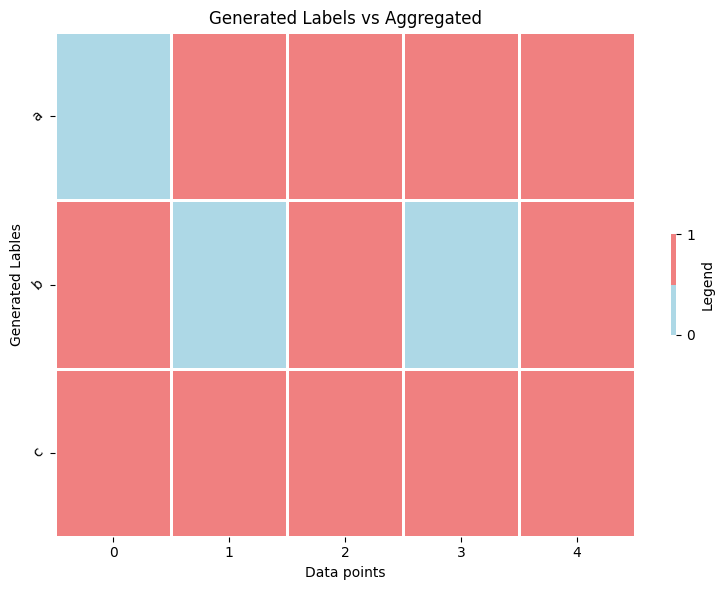

<function max>

In [5]:
eval.classification(all_results, strategy="majority", visualize=True, y_labels=y_labels)